In [ ]:
!gdown 'https://drive.google.com/uc?id=1P5z-mbu-hWUQwH2OQtL5KtSpzvmsqaGM'
!unrar e data.rar

Downloading...
From: https://drive.google.com/uc?id=1P5z-mbu-hWUQwH2OQtL5KtSpzvmsqaGM
To: /content/data.rar
100% 12.4M/12.4M [00:00<00:00, 46.8MB/s]

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from data.rar

Extracting  features.csv                                                  33% 67% 85%  OK 
Extracting  features_test.csv                                             99%  OK 
All OK


In [ ]:
import time
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
train = pd.read_csv('features.csv', index_col='match_id')

print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB
None


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


**Описание признаков в таблице**
* match_id: идентификатор матча в наборе данных
* start_time: время начала матча (unixtime)
* lobby_type: тип комнаты, в которой собираются игроки
* Наборы признаков для каждого игрока (игроки команды Radiant — префикс rN, Dire — dN):
 * r1_hero: герой игрока
 * r1_level: максимальный достигнутый уровень героя (за первые 5 игровых минут)
 * r1_xp: максимальный полученный опыт
 * r1_gold: достигнутая ценность героя
 * r1_lh: число убитых юнитов
 * r1_kills: число убитых игроков
 * r1_deaths: число смертей героя
 * r1_items: число купленных предметов
* Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
 * first_blood_time: игровое время первой крови
 * first_blood_team: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
 * first_blood_player1: игрок, причастный к событию
 * first_blood_player2: второй игрок, причастный к событию
* Признаки для каждой команды (префиксы radiant_ и dire_)
 * radiant_bottle_time: время первого приобретения командой предмета "bottle"
 * radiant_courier_time: время приобретения предмета "courier"
 * radiant_flying_courier_time: время приобретения предмета "flying_courier"
 * radiant_tpscroll_count: число предметов "tpscroll" за первые 5 минут
 * radiant_boots_count: число предметов "boots"
 * radiant_ward_observer_count: число предметов "ward_observer"
 * radiant_ward_sentry_count: число предметов "ward_sentry"
 * radiant_first_ward_time: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
* Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
 * duration: длительность
 * radiant_win: 1, если победила команда Radiant, 0 — иначе
 * Состояние башен и барраков к концу матча (см. описание полей набора данных)
   * tower_status_radiant
   * tower_status_dire
   * barracks_status_radiant
   * barracks_status_dire

In [ ]:
X_train = train.copy()
y_train = train["radiant_win"]

Найдём признаки, имеющие пропуски среди своих значений

In [ ]:
count_na = len(X_train) - X_train.count()
count_na[count_na > 0].sort_values(ascending=False) / len(X_train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

*   first_blood_player2 (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев. 
*   radiant_flying_courier_time (время приобретения предмета "flying_courier") - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры.
*   dire_flying_courier_time - аналогично radiant_flying_courier_time, процент почти тот же (26%).
*   first_blood_time (игровое время первой крови) - в 20% случаев первой крови нет в первые 5 минут игры.
*   first_blood_team (команда, совершившая первую кровь) - аналогично first_blood_time, процент совпадает (20%).
*   first_blood_player1 (игрок, причастный к событию) - аналогично first_blood_time, процент совпадает (20%).
*   dire_bottle_time (время первого приобретения командой предмета "bottle") - в 16% случаев команда не приобретает предмет "bottle" в первые 5 минут игры.
*   radiant_bottle_time - аналогично dire_bottle_time, процент почти тот же (16%).
*   radiant_first_ward_time (время установки командой первого "наблюдателя") - очень редкое явление, в 1% случаев команда не ставит "наблюдателя" в первые 5 минут игры.
*   dire_first_ward_time - аналогично radiant_first_ward_time, процент почти тот же (1%).
*   radiant_courier_time (время приобретения предмета "courier") - самое редкое явление, в 0.5% случаев команда не приобретает предмет "courier" в первые 5 минут игры.
*   dire_courier_time - аналогично radiant_courier_time, процент почти тот же (0.5%).

Заменим пропуски на нули.

In [ ]:
X_train = X_train.fillna(value=0)
y_train = y_train.fillna(value=0)
data_train = X_train.copy()

**Число убитых игроков**

Рассмотрим данные касательно команд, игравших за **Radiant**

In [ ]:
data1 = X_train.copy()
data1['radiant_kills'] = data1[['r1_kills','r2_kills','r3_kills','r4_kills','r5_kills']].sum(axis=1)
data1['radiant_xp'] = data1[['r1_xp','r2_xp','r3_xp','r4_xp','r5_xp']].sum(axis=1)

print("В среднем команда Radiant в первые 5 минут игры убивает {:.4f} игроков, в 99% матчей команда убивает {} игроков или меньше, а наибольшее количество убийств, когда-либо зарегистрированных, составляет {}.".format(data1['radiant_kills'].mean(), data1['radiant_kills'].quantile(0.99), data1['radiant_kills'].max()))

В среднем команда Radiant в первые 5 минут игры убивает 1.7234 игроков, в 99% матчей команда убивает 6.0 игроков или меньше, а наибольшее количество убийств, когда-либо зарегистрированных, составляет 19.


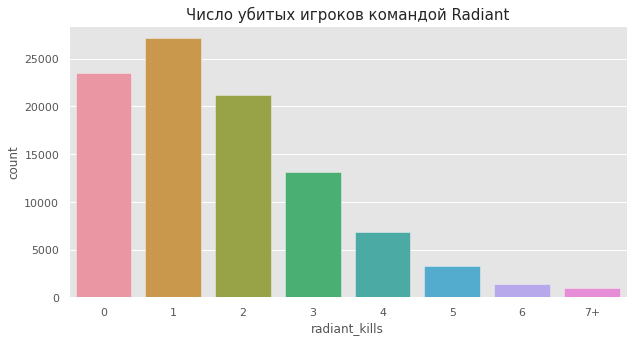

In [ ]:
data = data1.copy()
data.loc[data['radiant_kills'] > data['radiant_kills'].quantile(0.99)] = '7+'
plt.figure(figsize=(10,5))
sns.countplot(data['radiant_kills'].astype('str').sort_values())
plt.title("Число убитых игроков командой Radiant",fontsize=15)
plt.show()

Большинство команд, играя за Radiant, совершают 0, 1 или 2 убийства в течении первых 5 минут матча. Проверим, получают ли в это время опыт команды, совершающие 0 убийств.

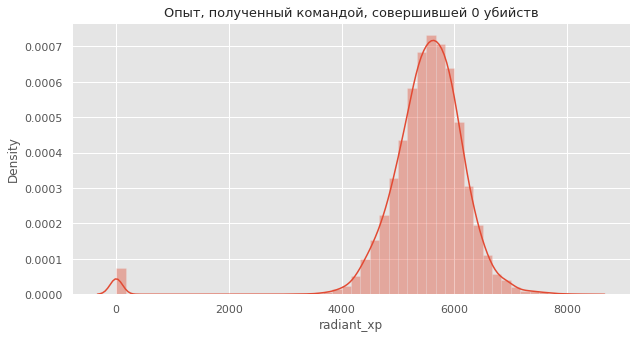

In [ ]:
data = data1.copy()
data = data[data['radiant_kills']==0]
plt.figure(figsize=(10,5))
plt.title("Опыт, полученный командой, совершившей 0 убийств",fontsize=13)
sns.distplot(data['radiant_xp'])
plt.show()

Значит команды, не успевшие совершить убийство, получают в это время опыт другими способами.

In [ ]:
data2 = data1[data1['radiant_kills'] == 0].copy()
print("{} команд ({:.4f}%) заработали 0 опыта. Это означает, что, возможно, команда была афк первые 5 минут матча.".format(len(data[data['radiant_xp'] == 0]), 100*len(data2[data2['radiant_xp']==0])/len(X_train)))

287 команд (0.2952%) заработали 0 опыта. Это означает, что, возможно, команда была афк первые 5 минут матча.


Рассмотрим исключения

In [ ]:
data = data1.copy()
data = data[data['radiant_kills']==0]
print("в {} матчах ({:.4f}%) команда Radiant выиграла без единого убийства в первые 5 минут игры.".format(len(data[data['radiant_win']==1]), 100*len(data[data['radiant_win']==1])/len(X_train)))


в 9803 матчах (10.0823%) команда Radiant выиграла без единого убийства в первые 5 минут игры.


Построим графики зависимости победы от количества убийств.

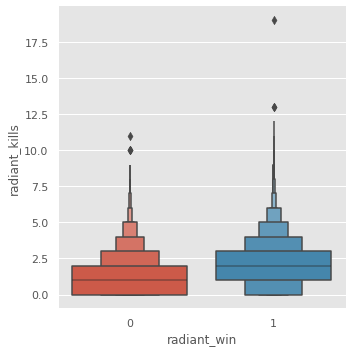

In [ ]:
sns.catplot(x='radiant_win', y='radiant_kills', kind='boxen', data=data1)
plt.show()

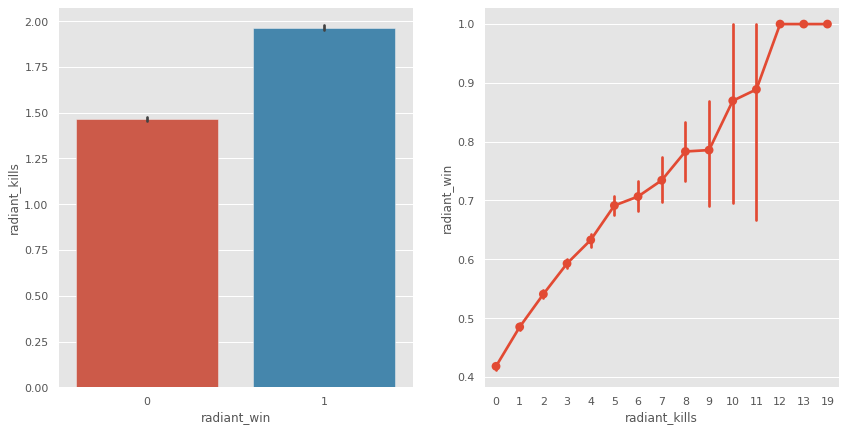

In [ ]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

sns.barplot(x='radiant_win', y='radiant_kills', ax=ax_1, data=data1)

sns.pointplot(x='radiant_kills', y='radiant_win', ax=ax_2, data=data1)

fig.set_figwidth(14)
fig.set_figheight(7)

plt.show()

Очевидно, большее число убийств увеличивает шансы на победу.

Рассмотрим данные касательно команд, игравших за **Dire**

In [ ]:
data1 = X_train.copy()
data1['dire_kills'] = data1[['d1_kills','d2_kills','d3_kills','d4_kills','d5_kills']].sum(axis=1)
data1['dire_xp'] = data1[['d1_xp','d2_xp','d3_xp','d4_xp','d5_xp']].sum(axis=1)

print("В среднем команда Dire в первые 5 минут игры убивает {:.4f} игроков, в 99% матчей команда убивает {} игроков или меньше, а наибольшее количество убийств, когда-либо зарегистрированных, составляет {}.".format(data1['dire_kills'].mean(), data1['dire_kills'].quantile(0.99), data1['dire_kills'].max()))

В среднем команда Dire в первые 5 минут игры убивает 1.7930 игроков, в 99% матчей команда убивает 7.0 игроков или меньше, а наибольшее количество убийств, когда-либо зарегистрированных, составляет 15.


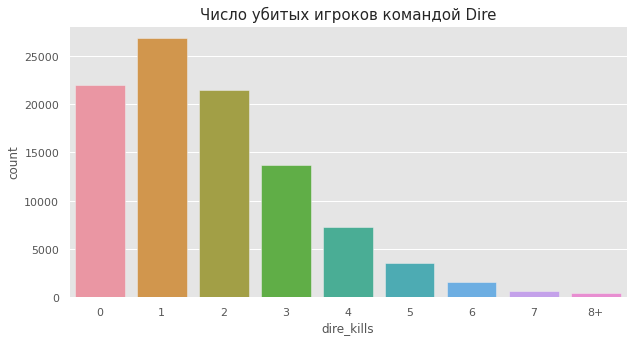

In [ ]:
data = data1.copy()
data.loc[data['dire_kills'] > data['dire_kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(10,5))
sns.countplot(data['dire_kills'].astype('str').sort_values())
plt.title("Число убитых игроков командой Dire",fontsize=15)
plt.show()

Команды, играющие за Dire, также в большинстве случаев совершают 0, 1 или 2 убийства. Проверим опыт команд, совершающих 0 убийств.

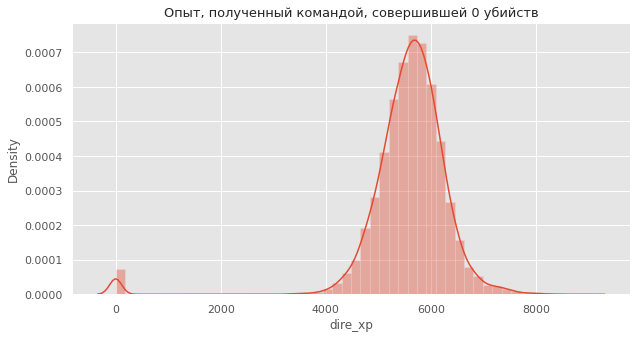

In [ ]:
data = data1.copy()
data = data[data['dire_kills']==0]
plt.figure(figsize=(10,5))
plt.title("Опыт, полученный командой, совершившей 0 убийств",fontsize=13)
sns.distplot(data['dire_xp'])
plt.show()

Значит команды, не успевшие совершить убийство, получают в это время опыт другими способами.

In [ ]:
data2 = data1[data1['dire_kills'] == 0].copy()
print("{} команд ({:.4f}%) заработали 0 опыта. Это означает, что, возможно, команда была афк первые 5 минут матча.".format(len(data[data['dire_xp'] == 0]), 100*len(data2[data2['dire_xp']==0])/len(X_train)))
print("А так как количество команд, получивших 0 опыта у команд Dire и Radiant совпадает, то, возможно, в это время случились какие-то проблемы на сервере.")

287 команд (0.2952%) заработали 0 опыта. Это означает, что, возможно, команда была афк первые 5 минут матча.
А так как количество команд, получивших 0 опыта у команд Dire и Radiant совпадает, то, возможно, в это время случились какие-то проблемы на сервере.


Рассмотрим исключения

In [ ]:
data = data1.copy()
data = data[data['dire_kills']==0]
print("в {} матчах ({:.4f}%) команда Dire выиграла без единого убийства в первые 5 минут игры.".format(len(data[data['radiant_win']==0]), 100*len(data[data['radiant_win']==0])/len(X_train)))

в 8271 матчах (8.5066%) команда Dire выиграла без единого убийства в первые 5 минут игры.


Построим графики зависимости количества убийств от победы (где radiant_win = 0 это победа команды Dire)

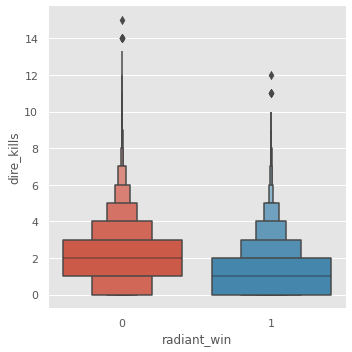

In [ ]:
sns.catplot(x='radiant_win', y='dire_kills', kind='boxen', data=data1)
plt.show()

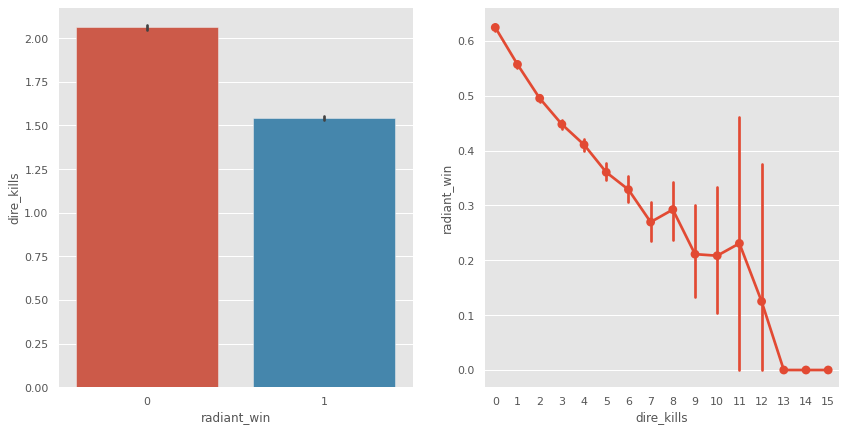

In [ ]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

sns.barplot(x='radiant_win', y='dire_kills', ax=ax_1, data=data1)

sns.pointplot(x='dire_kills', y='radiant_win', ax=ax_2, data=data1)

fig.set_figwidth(14)
fig.set_figheight(7)

plt.show()

У команды Dire также большее число убийств увеличивает шансы на победу.

Далее будем анализировать данные только на основе команд, играющих за Radiant, так как мы убедились, что показатели у Dire и Radiant почти совпадают.

**Построим корреляционную матрицу**

In [ ]:
data1 = X_train.copy()
data1['radiant_level'] = data1[['r1_level','r2_level','r3_level','r4_level','r5_level']].mean(axis=1)
data1['radiant_xp'] = data1[['r1_xp','r2_xp','r3_xp','r4_xp','r5_xp']].sum(axis=1)
data1['radiant_gold'] = data1[['r1_gold','r2_gold','r3_gold','r4_gold','r5_gold']].mean(axis=1)
data1['radiant_lh'] = data1[['r1_lh','r2_lh','r3_lh','r4_lh','r5_lh']].sum(axis=1)
data1['radiant_kills'] = data1[['r1_kills','r2_kills','r3_kills','r4_kills','r5_kills']].sum(axis=1)
data1['radiant_deaths'] = data1[['r1_deaths','r2_deaths','r3_deaths','r4_deaths','r5_deaths']].sum(axis=1)
data1['radiant_items'] = data1[['r1_items','r2_items','r3_items','r4_items','r5_items']].sum(axis=1) 
X_train_new = data1.copy()

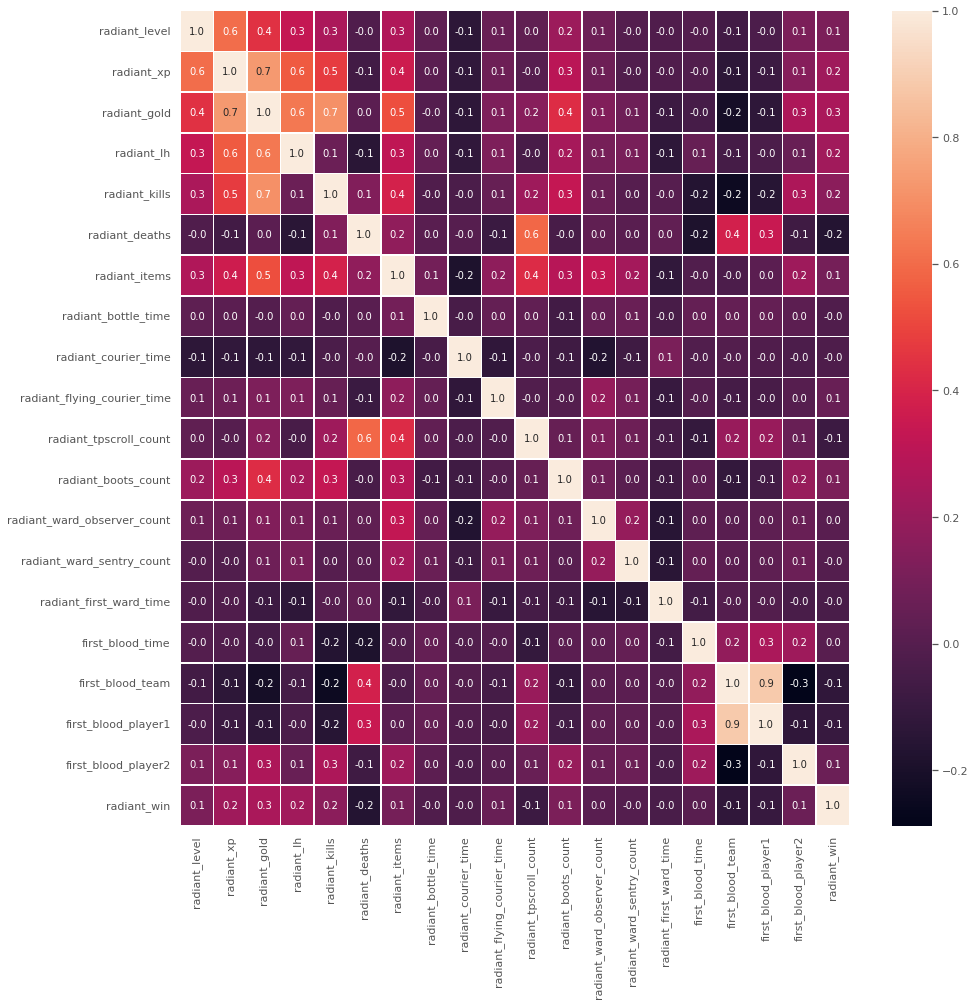

In [ ]:
data2 = data1[['radiant_level','radiant_xp','radiant_gold','radiant_lh','radiant_kills','radiant_deaths','radiant_items','radiant_bottle_time','radiant_courier_time','radiant_flying_courier_time','radiant_tpscroll_count','radiant_boots_count','radiant_ward_observer_count','radiant_ward_sentry_count','radiant_first_ward_time','first_blood_time','first_blood_team','first_blood_player1','first_blood_player2','radiant_win']]

f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data2.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Что касается целевой переменной (radiant_win), то существует несколько переменных относительно с высокой корреляцией. Самая высокая положительная корреляция - radiant_gold, а самая высокая отрицательная - radiant_deaths.

Давайте увеличим масштаб до топ-5 наиболее положительно коррелирующих переменных с целевой переменной.

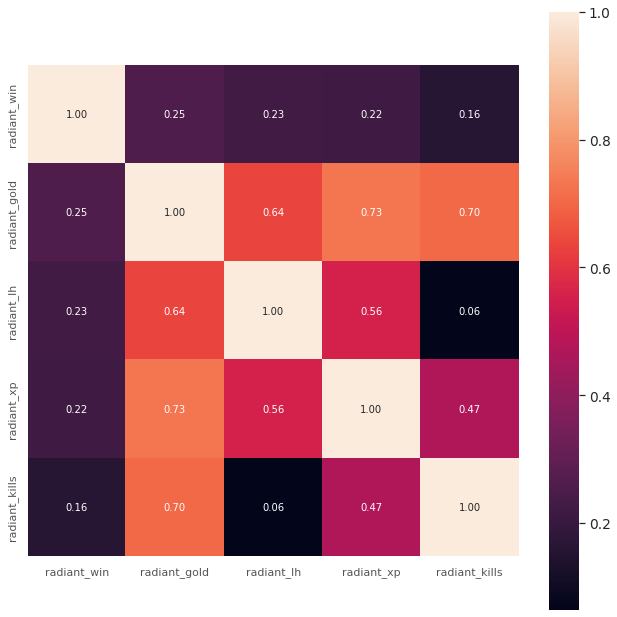

In [ ]:
k = 5 #количество переменных для тепловой карты
f,ax = plt.subplots(figsize=(11, 11))
cols = data2.corr().nlargest(k, 'radiant_win')['radiant_win'].index
cm = np.corrcoef(data2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Давайте построим график вышеуказанных переменных и переменной radiant_deaths в виде пар.

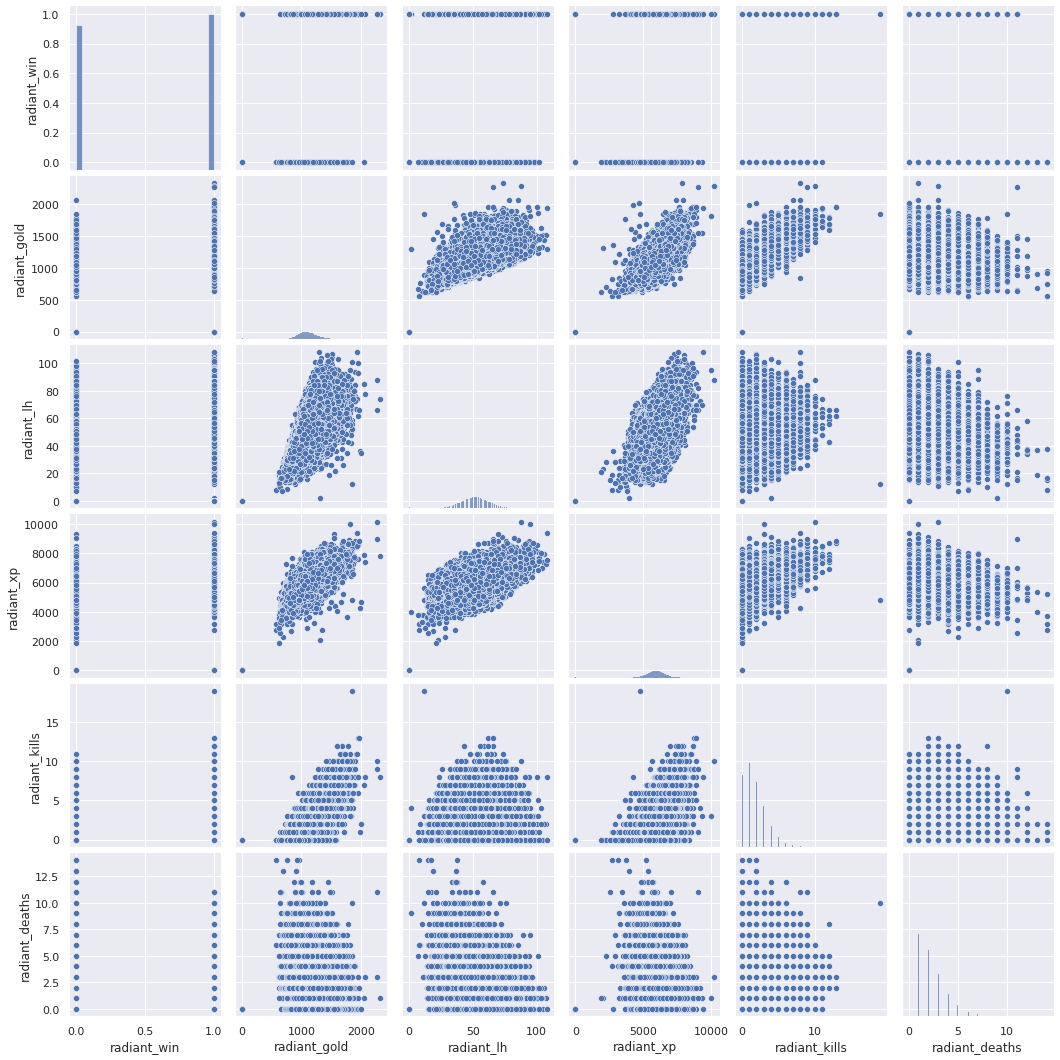

In [ ]:
sns.set()
cols = ['radiant_win', 'radiant_gold', 'radiant_lh', 'radiant_xp', 'radiant_kills', 'radiant_deaths']
sns.pairplot(data2[cols], size = 2.5)
plt.show()

**Максимально достигнутый уровень**

In [ ]:
data1 = X_train.copy()
data1['radiant_level'] = data1[['r1_level','r2_level','r3_level','r4_level','r5_level']].mean(axis=1)

print("В среднем средний уровень по команде составляет {:.1f}, 99% процентов команд имеют средний уровень {} или ниже, самый высокий средний уровень по команде составляет {}.".format(data1['radiant_level'].mean(), data1['radiant_level'].quantile(0.99), data1['radiant_level'].max()))

В среднем средний уровень по команде составляет 3.4, 99% процентов команд имеют средний уровень 4.0 или ниже, самый высокий средний уровень по команде составляет 4.8.


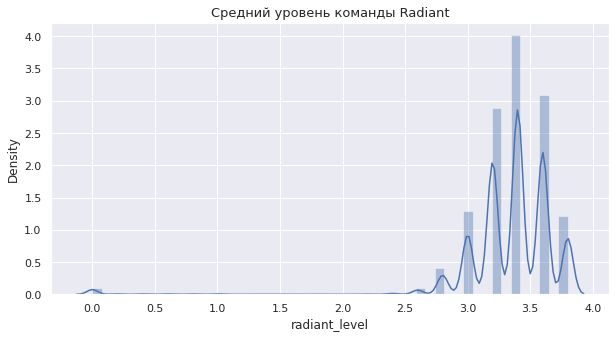

In [ ]:
data = data1.copy()
data = data[data['radiant_level'] < data1['radiant_level'].quantile(0.99)]
plt.figure(figsize=(10,5))
plt.title("Средний уровень команды Radiant",fontsize=13)
sns.distplot(data['radiant_level'])
plt.show()

In [ ]:
print("У {} команд ({:.4f}%) средний достигнутый уровень по команде составил 0. Это произошло, возможно, потому, что команды были афк, или возникли проблемы на сервере.".format(len(data[data['radiant_level'] == 0]), 100*len(data1[data1['radiant_level']==0])/len(X_train)))

У 736 команд (0.7570%) средний достигнутый уровень по команде составил 0. Это произошло, возможно, потому, что команды были афк, или возникли проблемы на сервере.


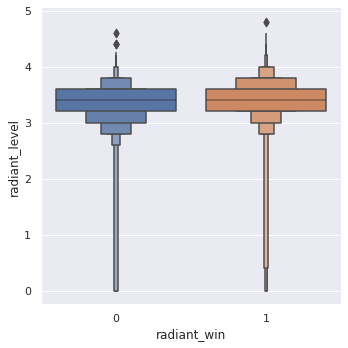

In [ ]:
sns.catplot(x='radiant_win', y='radiant_level', kind='boxen', data=data1)
plt.show()

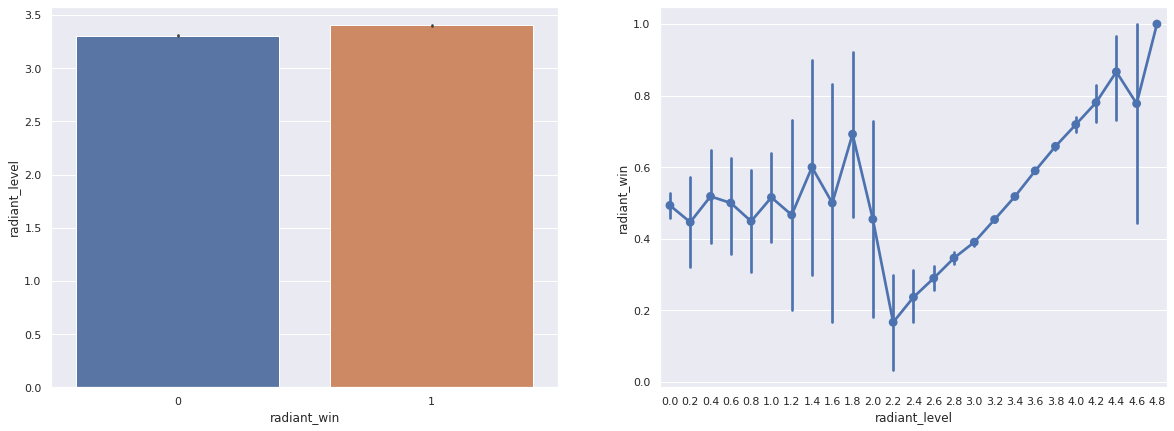

In [ ]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

sns.barplot(x='radiant_win', y='radiant_level', ax=ax_1, data=data1)

sns.pointplot(x='radiant_level', y='radiant_win', ax=ax_2, data=data1)

fig.set_figwidth(20)
fig.set_figheight(7)

plt.show()

Как мы видим, почти нет зависимости между высоким уровнем по команде и победой.

**Число купленных предметов**

In [ ]:
data1 = X_train.copy()
data1['radiant_items'] = data1[['r1_items','r2_items','r3_items','r4_items','r5_items']].sum(axis=1) 

print("В среднем количество предметов, купленных в команде, составляет {:.1f}, 99% процентов команд имеют {} или меньше предметов, самое большое количетво купленных предметов составляет {} предмета.".format(data1['radiant_items'].mean(), data1['radiant_items'].quantile(0.99), data1['radiant_items'].max()))

В среднем количество предметов, купленных в команде, составляет 41.4, 99% процентов команд имеют 56.0 или меньше предметов, самое большое количетво купленных предметов составляет 104 предмета.


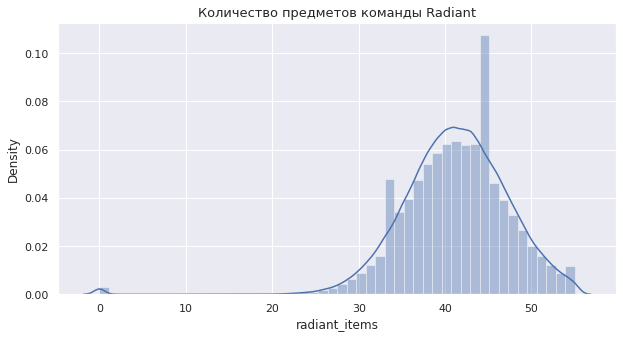

In [ ]:
data = data1.copy()
data = data[data['radiant_items'] < data1['radiant_items'].quantile(0.99)]
plt.figure(figsize=(10,5))
plt.title("Количество предметов команды Radiant",fontsize=13)
sns.distplot(data['radiant_items'])
plt.show()

In [ ]:
print("{} команд ({:.4f}%) купили 0 предметов за первые 5 минут матча. Это произошло, возможно, потому, что команды были афк, или возникли проблемы на сервере.".format(len(data[data['radiant_items'] == 0]), 100*len(data1[data1['radiant_items']==0])/len(X_train)))

332 команд (0.3415%) купили 0 предметов за первые 5 минут матча. Это произошло, возможно, потому, что команды были афк, или возникли проблемы на сервере.


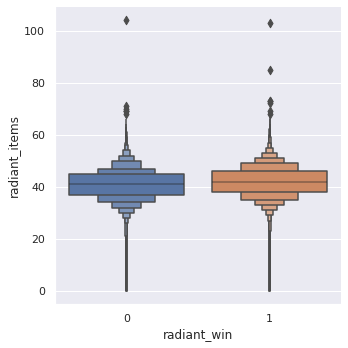

In [ ]:
sns.catplot(x='radiant_win', y='radiant_items', kind='boxen', data=data1)
plt.show()

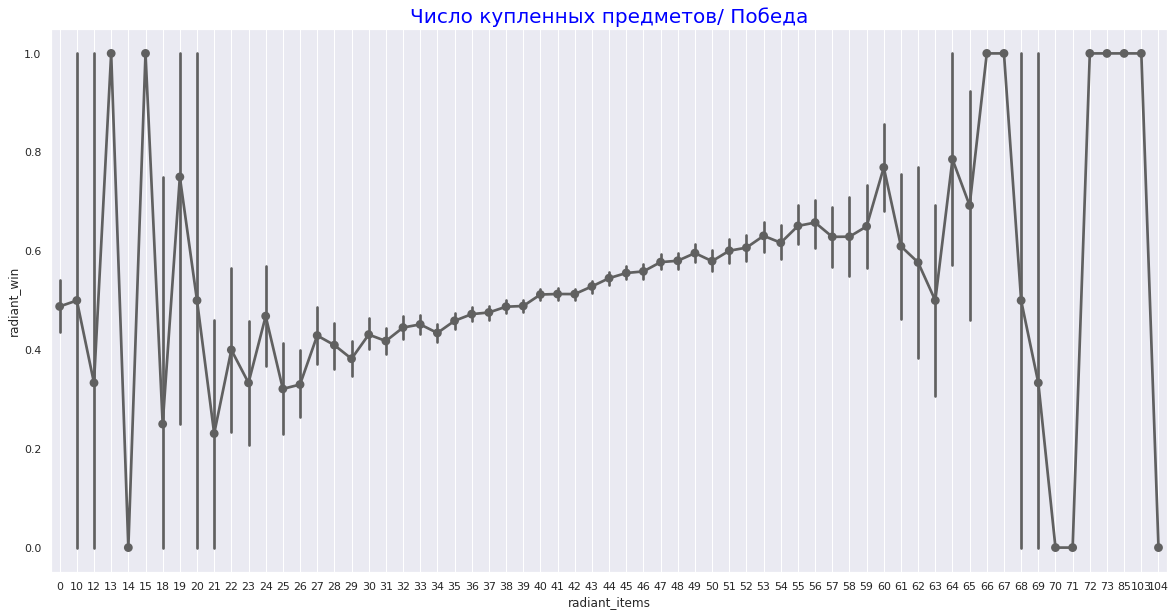

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='radiant_items', y='radiant_win', data=data1, color='#606060', alpha=0.8)
plt.title('Число купленных предметов/ Победа',fontsize = 20,color='blue')
plt.grid()
plt.show()

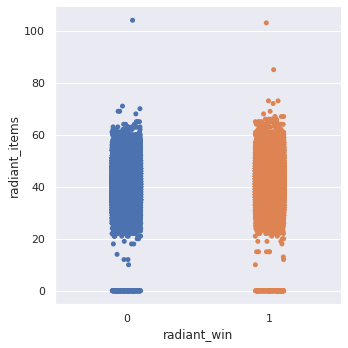

In [ ]:
sns.catplot(x='radiant_win', y='radiant_items', data=data1);

Как мы видим, большое количество купленных предметов почти никак не влияет на победу.

**Достигнутая ценность команды**

In [ ]:
data1 = X_train.copy()
data1['radiant_gold'] = data1[['r1_gold','r2_gold','r3_gold','r4_gold','r5_gold']].mean(axis=1)

print("В среднем средняя ценность игроков в команде, достигнутая к 5 минуте матча, составляет {:.1f}, 99% процентов команд имеют ценность {} или меньше, самое большое среднее ценностей игроков составляет {}.".format(data1['radiant_gold'].mean(), data1['radiant_gold'].quantile(0.99), data1['radiant_gold'].max()))

В среднем средняя ценность игроков в команде, достигнутая к 5 минуте матча, составляет 1103.9, 99% процентов команд имеют ценность 1533.4 или меньше, самое большое среднее ценностей игроков составляет 2331.8.


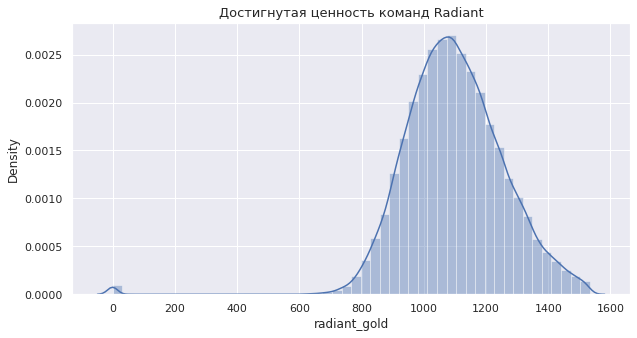

In [ ]:
data = data1.copy()
data = data[data['radiant_gold'] < data1['radiant_gold'].quantile(0.99)]
plt.figure(figsize=(10,5))
plt.title("Достигнутая ценность команд Radiant",fontsize=13)
sns.distplot(data['radiant_gold'])
plt.show()

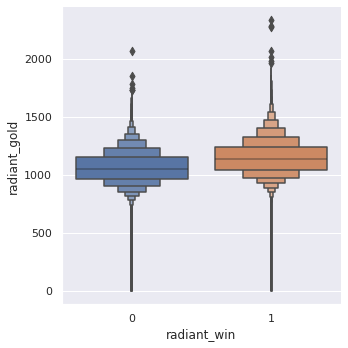

In [ ]:
sns.catplot(x='radiant_win', y='radiant_gold', kind='boxen', data=data1)
plt.show()

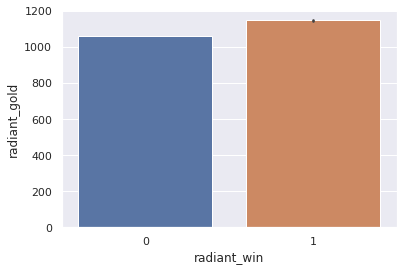

In [ ]:
sns.barplot(x='radiant_win', y='radiant_gold', data=data1)
plt.show()

Можно сказать, что достигнутая ценность команды слегка влияет на победу.

**Число убитых юнитов**

In [ ]:
data1 = X_train.copy()
data1['radiant_lh'] = data1[['r1_lh','r2_lh','r3_lh','r4_lh','r5_lh']].sum(axis=1)

print("В среднем сумма убитых юнитов в команде составляет {:.1f}, 99% процентов команд убивают {} юнитов или меньше, самое большое количество убитых юнитов составляет {}.".format(data1['radiant_lh'].mean(), data1['radiant_lh'].quantile(0.99), data1['radiant_lh'].max()))

В среднем сумма убитых юнитов в команде составляет 52.0, 99% процентов команд убивают 79.0 юнитов или меньше, самое большое количество убитых юнитов составляет 108.


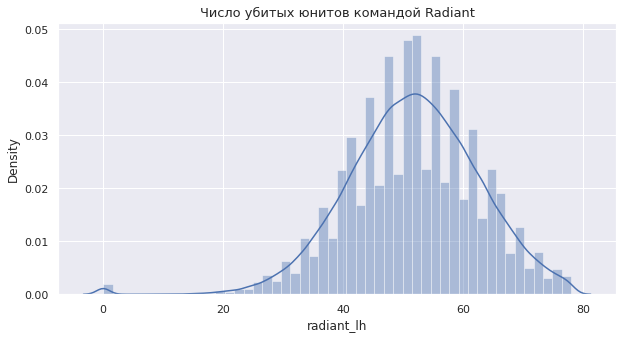

In [ ]:
data = data1.copy()
data = data[data['radiant_lh'] < data1['radiant_lh'].quantile(0.99)]
plt.figure(figsize=(10,5))
plt.title("Число убитых юнитов командой Radiant",fontsize=13)
sns.distplot(data['radiant_lh'])
plt.show()

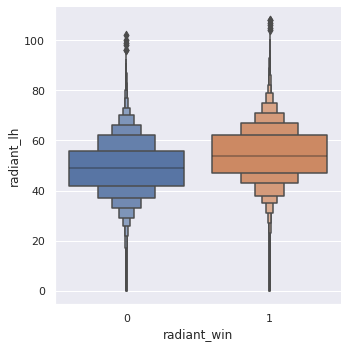

In [ ]:
sns.catplot(x='radiant_win', y='radiant_lh', kind='boxen', data=data1)
plt.show()

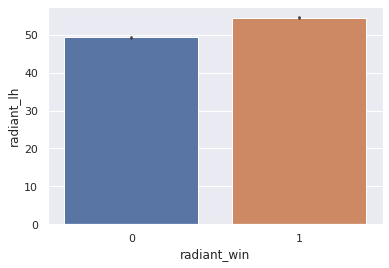

In [ ]:
sns.barplot(x='radiant_win', y='radiant_lh', data=data1)
plt.show()

Можно сказать, что число юнитов, убитых командой, немного влияет на победу.

# Обучим логическую регрессию

In [ ]:
X_train = X_train_new.copy()

X_train = X_train.loc[:, "start_time":"dire_first_ward_time"]

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [ ]:
def log_reg(X, y):
  scores = {}

  for i in range(-5, 6):
    c = 10.0 ** i
    print('С=', c)
    clf = LogisticRegression(C=c, random_state=42)

    start_time = datetime.datetime.now()
    score = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    print('Score:', score)
    print('Time elapsed:', datetime.datetime.now() - start_time)

    scores[i] = score
    print()
  
  return scores

def find_best_c(scores):
  scores = pd.Series(scores)
  best_c = 10.0 ** (scores.sort_values(ascending=False).head(1)).index[0]
  best_score = (scores.sort_values(ascending=False).head(1)).values[0]
  print('Лучший параметр регуляризации равен С =', best_c, ', при котором качество равно', best_score)

Уберём категориальные признаки из выборки.

In [ ]:
X_train = X_train.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis = 1)

На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясним из данных, сколько различных идентификаторов героев существует в данной игре.

In [ ]:
hero_features = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
N = max(np.unique(data_train[hero_features]))
print(len(np.unique(data_train[hero_features])), 'различных идентификаторов героев существует в данной игре')

108 различных идентификаторов героев существует в данной игре


Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire.

In [ ]:
X_pick = np.zeros((data_train.shape[0], N))

for i, match_id in enumerate(data_train.index):
    for p in range(1, 6):
        X_pick[i, data_train.loc[match_id, f"r{p}_hero"] - 1] = 1
        X_pick[i, data_train.loc[match_id, f"d{p}_hero"] - 1] = -1

X_pick = pd.DataFrame(X_pick, index=data_train.index, columns=[f"hero_{i}" for i in range(N)])

#X_train_new2 = pd.concat([X_train, X_pick], axis=1)
X_train = pd.concat([X_train, X_pick], axis=1)

Проведём кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации и поссчитаем качество.

С= 1e-05
Score: 0.699171062061466
Time elapsed: 0:00:02.828206

С= 0.0001
Score: 0.7250378099266611
Time elapsed: 0:00:03.444647

С= 0.001
Score: 0.7463327741266581
Time elapsed: 0:00:06.625488

С= 0.01
Score: 0.7517386754874054
Time elapsed: 0:00:11.953389

С= 0.1
Score: 0.7519459144269882
Time elapsed: 0:00:15.363159

С= 1.0
Score: 0.7519271614549912
Time elapsed: 0:00:15.483728

С= 10.0
Score: 0.7519255125108855
Time elapsed: 0:00:15.510306

С= 100.0
Score: 0.7519231205961315
Time elapsed: 0:00:15.459866

С= 1000.0
Score: 0.7519221819375883
Time elapsed: 0:00:15.331171

С= 10000.0
Score: 0.7519231353542537
Time elapsed: 0:00:15.451999

С= 100000.0
Score: 0.7519223535184529
Time elapsed: 0:00:15.443609



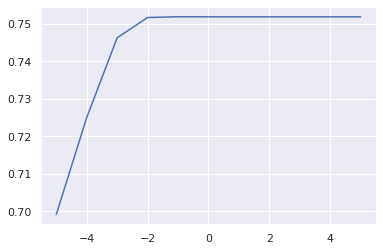


Лучший параметр регуляризации равен С = 0.1 , при котором качество равно 0.7519459144269882


In [ ]:
scores = log_reg(X_train, y_train)
pd.Series(scores).plot()
plt.show()
print()
find_best_c(scores)

Построем предсказания вероятностей победы команды Radiant для тестовой выборки. Убедимся, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [ ]:
clf = LogisticRegression(C=0.1, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42)

In [ ]:
data_test = pd.read_csv('features_test.csv', index_col='match_id')
data_test = data_test.fillna(value=0)
X_test = pd.DataFrame(scaler.transform(data_test), index=data_test.index, columns=data_test.columns)
X_test_new = X_test.drop(['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis = 1)


X_pick = np.zeros((data_test.shape[0], N))

for i, match_id in enumerate(data_test.index):
    for p in range(1, 6):
        X_pick[i, data_test.loc[match_id, f"r{p}_hero"] - 1] = 1
        X_pick[i, data_test.loc[match_id, f"d{p}_hero"] - 1] = -1

X_pick = pd.DataFrame(X_pick, index=data_test.index, columns=[f"hero_{i}" for i in range(N)])

X_test_new2 = pd.concat([X_test_new, X_pick], axis=1)
X_test_new2.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,hero_72,hero_73,hero_74,hero_75,hero_76,hero_77,hero_78,hero_79,hero_80,hero_81,hero_82,hero_83,hero_84,hero_85,hero_86,hero_87,hero_88,hero_89,hero_90,hero_91,hero_92,hero_93,hero_94,hero_95,hero_96,hero_97,hero_98,hero_99,hero_100,hero_101,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,-0.316298,-0.164037,-0.533149,2.621540,0.297642,1.50723,1.993380,2.074565,1.080012,2.558429,-0.578154,-0.931725,-0.282744,-0.439414,-0.168958,0.450562,-0.525343,-0.579877,-0.937075,-0.277630,0.335277,-0.328926,-0.781746,-0.524078,-0.573665,0.292704,-0.417344,-0.208467,-0.440022,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,0.607286,1.173453,-0.533149,-0.582396,-0.524101,0.59158,0.344425,-0.078385,0.297961,-0.529081,1.039791,-0.112095,-1.198079,-0.698973,-0.766270,-1.119305,1.030097,-0.579877,-0.113291,1.547460,1.980794,1.555606,1.565051,-0.524078,-0.573665,-0.941451,-0.417344,-0.588452,-0.394282,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,-1.176562,-0.832783,-0.533149,-0.582396,-0.934972,-0.32407,-0.401660,-0.447840,-0.819255,1.014674,2.657736,-0.931725,1.547927,1.303079,0.952390,1.459763,-0.525343,-0.579877,-0.113291,0.634915,0.763834,1.127504,1.788555,-0.524078,-0.573665,-1.764221,-0.417344,-0.984493,-1.036831,-1.138424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,-0.451669,-0.498410,-0.533149,-0.582396,-0.113229,1.50723,1.726664,1.157527,1.973784,-0.529081,-0.578154,-0.521910,0.632591,0.762180,2.413473,2.020430,2.585536,-0.579877,-0.525183,1.547460,1.449165,1.293007,1.900308,-0.524078,-0.573665,-0.118681,0.487716,0.028801,-0.973665,-0.694327,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,-0.314114,-0.052580,-0.533149,1.019572,-0.934972,-0.32407,-0.151163,-0.346679,-0.930976,1.014674,-0.578154,-0.931725,-0.282744,0.228542,-0.153414,0.002029,-0.525343,-0.579877,-0.113291,-1.190175,-1.219828,-1.043901,-0.669994,-0.524078,-0.573665,-0.118681,0.487716,1.844881,1.152193,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


count    17177.000000
mean         0.517031
std          0.220963
min          0.008432
25%          0.346091
50%          0.522135
75%          0.691758
max          0.996372
dtype: float64

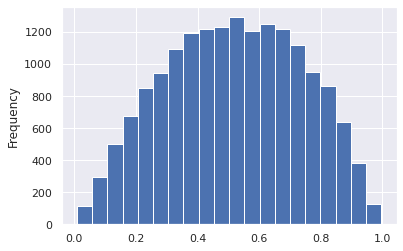

In [ ]:
y_pred = pd.Series(clf.predict_proba(X_test_new2)[:, 1])
y_pred.plot.hist(bins=20)
y_pred.describe()